In [1]:
import uproot as up
import numpy as np
import time
import iminuit
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
from multiprocessing import Pool
import multiprocessing

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"
sys.path.append('/software/pc24403/tfpcbpggsz/amp')
from PyD0ToKSpipi2018 import *

Kspipi = PyD0ToKSpipi2018()
Kspipi.init()
print('INFO: Loading the amplitude model')




Num GPUs Available:  6
INFO: Loading the amplitude model
D0ToKSpipi2018 ==> Initialization !


In [2]:
def get_mass(p1,p2):
    return ((p1[:,0]+p2[:,0])**2 - (p1[:,1]+p2[:,1])**2 - (p1[:,2]+p2[:,2])**2 - (p1[:,3]+p2[:,3])**2)


def get_p4(decay="b2dpi", cut='', index=2):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz", "B_M"]
        if cut == 'p':
            #file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/add_sw/lhcb_toy_{decay}_{index}_CPrange.root:BplusDalitzEventList'
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_sig_{index}.root:Bplus_DalitzEventList'

        else:
            #file_name = f'/software/pc24403/PCBPGGSZ/outputs/oy/mass_fit/add_sw/lhcb_toy_{decay}_{index}.root:BminusDalitzEventList'
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_sig_{index}.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    
    array = tree.arrays(branch_names)
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))



    return p1, p2, p3, p1bar, p2bar, p3bar

def load_int_amp(args):
    p1, p2, p3 = args

    return Kspipi.Amp_PFT(p1.tolist(), p2.tolist(), p3.tolist())

def getAmp(decay='b2dpi', cut='int'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar, B_M = get_p4_v2(decay=decay, cut=cut, comp='sig')
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    data = [(p1_np[i], p3_np[i], p2_np[i]) for i in range(len(p1_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitude.append(pool.map(load_int_amp, data))
    data_bar = [(p1bar_np[i], p2bar_np[i], p3bar_np[i]) for i in range(len(p1bar_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitudeBar.append(pool.map(load_int_amp, data_bar))
    
    end_time = time.time()
    print(f'Amplitude for {decay} loaded in {end_time-start_time} seconds')
    amplitude = np.array(amplitude)
    amplitudeBar = np.array(amplitudeBar)


    return amplitude, amplitudeBar
    
def get_p4_v2(decay="b2dpi", cut='', index=2, comp='sig'):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz", "B_M"]
        if cut == 'p':
            #file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/add_sw/lhcb_toy_{decay}_{index}_CPrange.root:BplusDalitzEventList'
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_sig_{index}.root:Bplus_DalitzEventList'

        else:
            #file_name = f'/software/pc24403/PCBPGGSZ/outputs/oy/mass_fit/add_sw/lhcb_toy_{decay}_{index}.root:BminusDalitzEventList'
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_sig_{index}.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    
    array = tree.arrays(branch_names, '(B_M>5150) & (B_M<5800)')
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))

    B_M = np.zeros(len(p1))
    if cut != 'int':
        
        B_M = np.asarray([array["B_M"]])


    return p1, p2, p3, p1bar, p2bar, p3bar, B_M


def getMass(decay='b2dpi', cut='int'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13

def getMass_v2(decay='b2dpi', cut='int', comp='sig'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar, B_M = get_p4_v2(decay=decay, cut=cut, comp=comp)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13, B_M

In [3]:
sys.path.append('/software/pc24403/tfpcbpggsz/func')
sys.path.append('/software/pc24403/tfpcbpggsz/amp')

mc_path = '/shared/scratch/pc24403/amp'

amp_Data_dk_dd_p, ampbar_Data_dk_dd_p = getAmp('b2dk_DD', 'p')
amp_Data_dk_dd_m, ampbar_Data_dk_dd_m = getAmp('b2dk_DD', 'm')

amp_dk_dd_p = np.load(mc_path + '/Int_b2dk_DD_p_amp.npy')
ampbar_dk_dd_p = np.load(mc_path + '/Int_b2dk_DD_p_ampbar.npy')
amp_dk_dd_m = np.load(mc_path + '/Int_b2dk_DD_m_amp.npy')
ampbar_dk_dd_m = np.load(mc_path + '/Int_b2dk_DD_m_ampbar.npy')


Amplitude for b2dk_DD loaded in 1.4808433055877686 seconds
Amplitude for b2dk_DD loaded in 0.8462173938751221 seconds


# Prepare Mass PDF

In [4]:
sys.path.append('/software/pc24403/tfpcbpggsz/func')
from massshape import *


def preparePdf_data(Bu_M, varDict, mode='b2dk_LL'):
    '''
    Import constructed data sets and construct PDFs with RooFit functions.
    PDFs and data sets are saved together in a new RooWorkspace

    Args:
        configDict: a dictionary containing the values of PDF shape parameters
        year: which subset of data to fit, can be any single year of data taking,
              or 'Run1', 'Run2', 'All'.
    ''' 

    pdfList = {}

    print('--- Constructing signal pdfs...')
    varDict['DD_dk_Gauss_frac'] = 1 - varDict['DD_dk_Cruijff_frac']
    varDict['DD_dpi_Gauss_frac'] = 1- varDict['DD_dpi_Cruijff_frac']
    varDict['LL_dk_Gauss_frac'] = 1 - varDict['LL_dk_Cruijff_frac']
    varDict['LL_dpi_Gauss_frac'] = 1 - varDict['LL_dpi_Cruijff_frac']

    pdf_sig_Cruijff_DK_KsPiPi_DD  = lambda Bu_M: CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dk_DD'], varDict['sigma_dk_DD'], varDict['DD_dk_Cruijff_alpha_L'], varDict['DD_dk_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DK_KsPiPi_DD    = lambda Bu_M: Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dk_DD'])

    pdf_sig_Cruijff_DPi_KsPiPi_DD = lambda Bu_M: CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_DD'], varDict['sigma_dpi_DD'], varDict['DD_dpi_Cruijff_alpha_L'], varDict['DD_dpi_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DPi_KsPiPi_DD   = lambda Bu_M: Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_DD'])
    pdf_sig_Cruijff_DK_KsPiPi_LL  = lambda Bu_M: CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dk_LL'], varDict['sigma_dk_LL'], varDict['LL_dk_Cruijff_alpha_L'], varDict['LL_dk_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DK_KsPiPi_LL    = lambda Bu_M: Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dk_LL'])
    pdf_sig_Cruijff_DPi_KsPiPi_LL = lambda Bu_M: CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_LL'], varDict['sigma_dpi_LL'], varDict['LL_dpi_Cruijff_alpha_L'], varDict['LL_dpi_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DPi_KsPiPi_LL   = lambda Bu_M: Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_LL'])


    if mode == 'b2dk_LL':
        pdfList['sig'] = lambda Bu_M: (norm_pdf(pdf_sig_Cruijff_DK_KsPiPi_LL(Bu_M)) * varDict['LL_dk_Cruijff_frac'] +  norm_pdf(pdf_sig_Gauss_DK_KsPiPi_LL(Bu_M)) * varDict['LL_dk_Gauss_frac'])
    elif mode == 'b2dpi_LL':
        pdfList['sig'] = lambda Bu_M: (norm_pdf(pdf_sig_Cruijff_DPi_KsPiPi_LL(Bu_M)) * varDict['LL_dpi_Cruijff_frac'] +  norm_pdf(pdf_sig_Gauss_DPi_KsPiPi_LL(Bu_M)) *  varDict['LL_dpi_Gauss_frac'])
    elif mode == 'b2dk_DD':
        pdfList['sig'] = lambda Bu_M: (norm_pdf(pdf_sig_Cruijff_DK_KsPiPi_DD(Bu_M)) * varDict['DD_dk_Cruijff_frac'] +  norm_pdf(pdf_sig_Gauss_DK_KsPiPi_DD(Bu_M)) *  varDict['DD_dk_Gauss_frac'])
    elif mode == 'b2dpi_DD':
        pdfList['sig'] = lambda Bu_M: (norm_pdf(pdf_sig_Cruijff_DPi_KsPiPi_DD(Bu_M)) * varDict['DD_dpi_Cruijff_frac'] + norm_pdf(pdf_sig_Gauss_DPi_KsPiPi_DD(Bu_M)) * varDict['DD_dpi_Gauss_frac'])    
 

    print('--- Constructing misID pdfs...')
    pdf_misid_CB1_DK_KsPiPi_LL = lambda Bu_M: CBShape(Bu_M, varDict['LL_d2kspp_dpi_to_dk_misID_mean1'], varDict['LL_d2kspp_dpi_to_dk_misID_width1'], varDict['LL_d2kspp_dpi_to_dk_misID_alpha1'], varDict['LL_d2kspp_dpi_to_dk_misID_n1'])
    pdf_misid_CB2_DK_KsPiPi_LL = lambda Bu_M: CBShape(Bu_M, varDict['LL_d2kspp_dpi_to_dk_misID_mean1'], varDict['LL_d2kspp_dpi_to_dk_misID_width2'], varDict['LL_d2kspp_dpi_to_dk_misID_alpha2'], varDict['LL_d2kspp_dpi_to_dk_misID_n1'])
    pdf_misid_CB1_DK_KsPiPi_DD = lambda Bu_M: CBShape(Bu_M, varDict['DD_d2kspp_dpi_to_dk_misID_mean1'], varDict['DD_d2kspp_dpi_to_dk_misID_width1'], varDict['DD_d2kspp_dpi_to_dk_misID_alpha1'], varDict['DD_d2kspp_dpi_to_dk_misID_n1'])
    pdf_misid_CB2_DK_KsPiPi_DD = lambda Bu_M: CBShape(Bu_M, varDict['DD_d2kspp_dpi_to_dk_misID_mean1'], varDict['DD_d2kspp_dpi_to_dk_misID_width2'], varDict['DD_d2kspp_dpi_to_dk_misID_alpha2'], varDict['DD_d2kspp_dpi_to_dk_misID_n1'])
    if mode == 'b2dk_LL':
        pdfList['misid'] = lambda Bu_M: (norm_pdf(pdf_misid_CB1_DK_KsPiPi_LL(Bu_M)) * varDict['LL_d2kspp_dpi_to_dk_misID_frac1'] + norm_pdf(pdf_misid_CB2_DK_KsPiPi_LL(Bu_M)) * varDict['LL_d2kspp_dpi_to_dk_misID_frac2'])
    elif mode == 'b2dk_DD':
        pdfList['misid'] = lambda Bu_M: (norm_pdf(pdf_misid_CB1_DK_KsPiPi_DD(Bu_M)) * varDict['DD_d2kspp_dpi_to_dk_misID_frac1'] + norm_pdf(pdf_misid_CB2_DK_KsPiPi_DD(Bu_M)) * varDict['DD_d2kspp_dpi_to_dk_misID_frac2'])
    elif mode == 'b2dpi_LL':
        pdfList['misid'] = lambda Bu_M: (CBShape(Bu_M, varDict['LL_dk_to_dpi_misID_mean1'], varDict['LL_dk_to_dpi_misID_width1'], varDict['LL_dk_to_dpi_misID_alpha1'], varDict['LL_dk_to_dpi_misID_n1']))
    elif mode == 'b2dpi_DD':
        pdfList['misid'] = lambda Bu_M: (CBShape(Bu_M, varDict['DD_dk_to_dpi_misID_mean1'], varDict['DD_dk_to_dpi_misID_width1'], varDict['DD_dk_to_dpi_misID_alpha1'], varDict['DD_dk_to_dpi_misID_n1']))

    print('--- Constructing low-mass pdfs...')
    varDict['low_sigma_k_DD'] = varDict['low_sigma_pi_DD']/varDict['low_sigma_pi_over_k_ratio']
    varDict['low_sigma_k_LL'] = varDict['low_sigma_pi_LL']/varDict['low_sigma_pi_over_k_ratio']
    varDict['low_sigma_gamma_dk'] = varDict['low_sigma_gamma']/varDict['low_sigma_pi_over_k_ratio_gamma']

    # B2Dsth (missing pi)
    pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_LL'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_DD'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_LL  = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bd_Dstarph_D0pi_dpi'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_LL'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_DD  = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bd_Dstarph_D0pi_dpi'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_DD'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL  = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'],  varDict['low_b_Bu_Dstar0h_D0pi0_dk'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_LL'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD  = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'],  varDict['low_b_Bu_Dstar0h_D0pi0_dk'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_DD'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DK_KsPiPi_LL   = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],   varDict['low_b_Bd_Dstarph_D0pi_dk'],   varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_LL'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DK_KsPiPi_DD   = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],   varDict['low_b_Bd_Dstarph_D0pi_dk'],   varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_DD'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    # DK misid
    pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'], varDict['low_b_Bu_Dstar0h_D0pi0_dk'], varDict['low_csi_pi'], varDict['m1pi_LL'], varDict['s1pi_LL'], varDict['m2pi_LL'], varDict['s2pi_LL'], varDict['m3pi_LL'], varDict['s3pi_LL'], varDict['m4pi_LL'], varDict['s4pi_LL'], varDict['f1pi_LL'], varDict['f2pi_LL'], varDict['f3pi_LL'])
    pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'], varDict['low_b_Bu_Dstar0h_D0pi0_dk'], varDict['low_csi_pi'], varDict['m1pi_DD'], varDict['s1pi_DD'], varDict['m2pi_DD'], varDict['s2pi_DD'], varDict['m3pi_DD'], varDict['s3pi_DD'], varDict['m4pi_DD'], varDict['s4pi_DD'], varDict['f1pi_DD'], varDict['f2pi_DD'], varDict['f3pi_DD'])
    pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_LL  = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],  varDict['low_b_Bd_Dstarph_D0pi_dk'],  varDict['low_csi_pi'], varDict['m1pi_LL'], varDict['s1pi_LL'], varDict['m2pi_LL'], varDict['s2pi_LL'], varDict['m3pi_LL'], varDict['s3pi_LL'], varDict['m4pi_LL'], varDict['s4pi_LL'], varDict['f1pi_LL'], varDict['f2pi_LL'], varDict['f3pi_LL'])
    pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_DD  = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],  varDict['low_b_Bd_Dstarph_D0pi_dk'],  varDict['low_csi_pi'], varDict['m1pi_DD'], varDict['s1pi_DD'], varDict['m2pi_DD'], varDict['s2pi_DD'], varDict['m3pi_DD'], varDict['s3pi_DD'], varDict['m4pi_DD'], varDict['s4pi_DD'], varDict['f1pi_DD'], varDict['f2pi_DD'], varDict['f3pi_DD'])
    # DPi misid
    pdf_low_misID_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_LL'], varDict['s1pi_pi_LL'], varDict['m2pi_pi_LL'], varDict['s2pi_pi_LL'], varDict['m3pi_pi_LL'], varDict['s3pi_pi_LL'], varDict['m4pi_pi_LL'], varDict['s4pi_pi_LL'], varDict['f1pi_pi_LL'], varDict['f2pi_pi_LL'], varDict['f3pi_pi_LL'])
    pdf_low_misID_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_DD'], varDict['s1pi_pi_DD'], varDict['m2pi_pi_DD'], varDict['s2pi_pi_DD'], varDict['m3pi_pi_DD'], varDict['s3pi_pi_DD'], varDict['m4pi_pi_DD'], varDict['s4pi_pi_DD'], varDict['f1pi_pi_DD'], varDict['f2pi_pi_DD'], varDict['f3pi_pi_DD'])
    pdf_low_misID_Bd_Dstarph_D0pi_DPi_KsPiPi_LL  = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_LL'], varDict['s1pi_pi_LL'], varDict['m2pi_pi_LL'], varDict['s2pi_pi_LL'], varDict['m3pi_pi_LL'], varDict['s3pi_pi_LL'], varDict['m4pi_pi_LL'], varDict['s4pi_pi_LL'], varDict['f1pi_pi_LL'], varDict['f2pi_pi_LL'], varDict['f3pi_pi_LL'])
    pdf_low_misID_Bd_Dstarph_D0pi_DPi_KsPiPi_DD  = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_DD'], varDict['s1pi_pi_DD'], varDict['m2pi_pi_DD'], varDict['s2pi_pi_DD'], varDict['m3pi_pi_DD'], varDict['s3pi_pi_DD'], varDict['m4pi_pi_DD'], varDict['s4pi_pi_DD'], varDict['f1pi_pi_DD'], varDict['f2pi_pi_DD'], varDict['f3pi_pi_DD'])
    # B2Dsth (missing photon) 
    pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL = lambda Bu_M: HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma'],    varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD = lambda Bu_M: HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma'],    varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL  = lambda Bu_M: HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'],  varDict['low_b_Bu_Dstar0h_D0gamma_dk'],  varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma_dk'], varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD  = lambda Bu_M: HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'],  varDict['low_b_Bu_Dstar0h_D0gamma_dk'],  varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma_dk'], varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    # DK misid
    pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL = lambda Bu_M: HILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'], varDict['low_b_Bu_Dstar0h_D0gamma_dk'], varDict['low_csi_gamma'], varDict['m1ga'], varDict['s1ga'], varDict['m2ga'], varDict['s2ga'], varDict['m3ga'], varDict['s3ga'], varDict['m4ga'], varDict['s4ga'], varDict['f1ga'], varDict['f2ga'], varDict['f3ga'])
    pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD = lambda Bu_M: HILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'], varDict['low_b_Bu_Dstar0h_D0gamma_dk'], varDict['low_csi_gamma'], varDict['m1ga'], varDict['s1ga'], varDict['m2ga'], varDict['s2ga'], varDict['m3ga'], varDict['s3ga'], varDict['m4ga'], varDict['s4ga'], varDict['f1ga'], varDict['f2ga'], varDict['f3ga'])
    # DPi misid
    pdf_low_misID_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL = lambda Bu_M: ßHILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['m1ga_pi'], varDict['s1ga_pi'], varDict['m2ga_pi'], varDict['s2ga_pi'], varDict['m3ga_pi'], varDict['s3ga_pi'], varDict['m4ga_pi'], varDict['s4ga_pi'], varDict['f1ga_pi'], varDict['f2ga_pi'], varDict['f3ga_pi'])
    pdf_low_misID_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD = lambda Bu_M: ßHILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['m1ga_pi'], varDict['s1ga_pi'], varDict['m2ga_pi'], varDict['s2ga_pi'], varDict['m3ga_pi'], varDict['s3ga_pi'], varDict['m4ga_pi'], varDict['s4ga_pi'], varDict['f1ga_pi'], varDict['f2ga_pi'], varDict['f3ga_pi'])

    # B2Dhpi
    # DPi
    pdf_B2Dpipi_1_DPi_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_I_B2Dpipi'],  varDict['low_b_I_B2Dpipi'],  varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_I_B2Dpipi'],  varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_1_DPi_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_I_B2Dpipi'],  varDict['low_b_I_B2Dpipi'],  varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_I_B2Dpipi'],  varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_2_DPi_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_II_B2Dpipi'], varDict['low_b_II_B2Dpipi'], varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_II_B2Dpipi'], varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_2_DPi_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_II_B2Dpipi'], varDict['low_b_II_B2Dpipi'], varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_II_B2Dpipi'], varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_DPi_KsPiPi_LL   = lambda Bu_M: pdf_B2Dpipi_1_DPi_KsPiPi_LL(Bu_M) * varDict['low_frac_B2Dpipi'] + pdf_B2Dpipi_2_DPi_KsPiPi_LL(Bu_M) * (1- varDict['low_frac_B2Dpipi'])
    pdf_B2Dpipi_DPi_KsPiPi_DD   = lambda Bu_M: pdf_B2Dpipi_1_DPi_KsPiPi_DD(Bu_M) * varDict['low_frac_B2Dpipi'] + pdf_B2Dpipi_2_DPi_KsPiPi_DD(Bu_M) * (1- varDict['low_frac_B2Dpipi'])
    # DK
    pdf_B2DKpi_1_DK_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_B2DKpi'], varDict['low_b_B2DKpi'], varDict['low_csi_B2DKpi'], varDict['low_global_shift'], varDict['low_sigma_B2DKpi'], varDict['low_ratio_B2DKpi'], varDict['low_f_B2DKpi'])
    pdf_B2DKpi_1_DK_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_B2DKpi'], varDict['low_b_B2DKpi'], varDict['low_csi_B2DKpi'], varDict['low_global_shift'], varDict['low_sigma_B2DKpi'], varDict['low_ratio_B2DKpi'], varDict['low_f_B2DKpi'])
    pdf_B2DKpi_2_DK_KsPiPi_LL = lambda Bu_M: Gaussian(Bu_M, varDict['low_mu_B2DKpi'], varDict['low_sigma_gaus_B2DKpi'])
    pdf_B2DKpi_2_DK_KsPiPi_DD = lambda Bu_M: Gaussian(Bu_M, varDict['low_mu_B2DKpi'], varDict['low_sigma_gaus_B2DKpi'])
    pdf_B2DKpi_DK_KsPiPi_LL   = lambda Bu_M: pdf_B2DKpi_1_DK_KsPiPi_LL(Bu_M) * varDict['low_frac_B2DKpi'] + pdf_B2DKpi_2_DK_KsPiPi_LL(Bu_M) * (1- varDict['low_frac_B2DKpi'])
    pdf_B2DKpi_DK_KsPiPi_DD   = lambda Bu_M: pdf_B2DKpi_1_DK_KsPiPi_DD(Bu_M) * varDict['low_frac_B2DKpi'] + pdf_B2DKpi_2_DK_KsPiPi_DD(Bu_M) * (1- varDict['low_frac_B2DKpi'])
    # DK misid
    pdf_low_misID_B2Dpipi_DK_KsPiPi_LL = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_B2Dpipi_misID'], varDict['low_b_B2Dpipi_misID'], varDict['low_csi_B2Dpipi'], varDict['low_m1_B2Dpipi_misID'], varDict['low_s1_B2Dpipi_misID'], varDict['low_m2_B2Dpipi_misID'], varDict['low_s2_B2Dpipi_misID'], varDict['low_m3_B2Dpipi_misID'], varDict['low_s3_B2Dpipi_misID'], varDict['low_m4_B2Dpipi_misID'], varDict['low_s4_B2Dpipi_misID'], varDict['low_f1_B2Dpipi_misID'], varDict['low_f2_B2Dpipi_misID'], varDict['low_f3_B2Dpipi_misID'])
    pdf_low_misID_B2Dpipi_DK_KsPiPi_DD = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_B2Dpipi_misID'], varDict['low_b_B2Dpipi_misID'], varDict['low_csi_B2Dpipi'], varDict['low_m1_B2Dpipi_misID'], varDict['low_s1_B2Dpipi_misID'], varDict['low_m2_B2Dpipi_misID'], varDict['low_s2_B2Dpipi_misID'], varDict['low_m3_B2Dpipi_misID'], varDict['low_s3_B2Dpipi_misID'], varDict['low_m4_B2Dpipi_misID'], varDict['low_s4_B2Dpipi_misID'], varDict['low_f1_B2Dpipi_misID'], varDict['low_f2_B2Dpipi_misID'], varDict['low_f3_B2Dpipi_misID'])

    # Bs pdf
    pdf_low_Bs2DKPi_DK_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bs2DKpi'], varDict['low_b_Bs2DKpi'], varDict['low_csi_Bs2DKpi'], varDict['low_global_shift'], varDict['low_sigma_Bs2DKpi'], varDict['low_ratio_Bs2DKpi'], varDict['low_f_Bs2DKpi'])
    pdf_low_Bs2DKPi_DK_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bs2DKpi'], varDict['low_b_Bs2DKpi'], varDict['low_csi_Bs2DKpi'], varDict['low_global_shift'], varDict['low_sigma_Bs2DKpi'], varDict['low_ratio_Bs2DKpi'], varDict['low_f_Bs2DKpi'])

    if mode == 'b2dk_LL':
        pdfList['low_Bs2DKPi'] = lambda Bu_M: (pdf_low_Bs2DKPi_DK_KsPiPi_LL(Bu_M))
    elif mode == 'b2dk_DD':
        pdfList['low_Bs2DKPi'] = lambda Bu_M: norm_pdf(pdf_low_Bs2DKPi_DK_KsPiPi_DD(Bu_M))


    # Combine: with fractions
    if 'frac_low_Bu_Dstar0h_D0pi0_DPi' in varDict.keys():
        # Combine: DPi lowmass
        pdf_low_dpi_DPi_KsPiPi_LL = lambda Bu_M: varDict['frac_low_Bu_Dstar0h_D0pi0_DPi']*norm_pdf(pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL(Bu_M)) + varDict['frac_low_Bd_Dstarph_D0pi_DPi']* norm_pdf(pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_LL(Bu_M)) + varDict['frac_low_Bu_Dstar0h_D0gamma_DPi'] * norm_pdf(pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL(Bu_M)) + varDict['frac_low_B2Dpipi_DPi'] * norm_pdf(pdf_B2Dpipi_DPi_KsPiPi_LL(Bu_M))
        pdf_low_dpi_DPi_KsPiPi_DD = lambda Bu_M: varDict['frac_low_Bu_Dstar0h_D0pi0_DPi']*norm_pdf(pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD(Bu_M)) + varDict['frac_low_Bd_Dstarph_D0pi_DPi']* norm_pdf(pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_DD(Bu_M)) + varDict['frac_low_Bu_Dstar0h_D0gamma_DPi'] * norm_pdf(pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD(Bu_M)) + varDict['frac_low_B2Dpipi_DPi'] * norm_pdf(pdf_B2Dpipi_DPi_KsPiPi_DD(Bu_M))
        # Combine: DK lowmass
        pdf_low_dk_DK_KsPiPi_LL = lambda Bu_M: varDict['frac_low_Bu_Dstar0h_D0pi0_DK']*norm_pdf(pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL(Bu_M)) + varDict['frac_low_Bd_Dstarph_D0pi_DK']* norm_pdf(pdf_Bd_Dstarph_D0pi_DK_KsPiPi_LL(Bu_M)) + varDict['frac_low_Bu_Dstar0h_D0gamma_DK']* norm_pdf(pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL(Bu_M)) + varDict['frac_low_B2DKpi_DK']* norm_pdf(pdf_B2DKpi_DK_KsPiPi_LL(Bu_M))

        pdf_low_dk_DK_KsPiPi_DD = lambda Bu_M: varDict['frac_low_Bu_Dstar0h_D0pi0_DK']*norm_pdf(pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD(Bu_M)) + varDict['frac_low_Bd_Dstarph_D0pi_DK']* norm_pdf(pdf_Bd_Dstarph_D0pi_DK_KsPiPi_DD(Bu_M)) + varDict['frac_low_Bu_Dstar0h_D0gamma_DK'] * norm_pdf(pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD(Bu_M)) + varDict['frac_low_B2DKpi_DK']* norm_pdf(pdf_B2DKpi_DK_KsPiPi_DD(Bu_M))
        # Combine: DK misid
        pdf_low_misID_DK_KsPiPi_LL = lambda Bu_M: varDict['frac_low_misID_Bu_Dstar0h_D0pi0_DK']* norm_pdf(pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL(Bu_M)) + varDict['frac_low_misID_Bd_Dstarph_D0pi_DK']* norm_pdf(pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_LL(Bu_M)) + varDict['frac_low_misID_Bu_Dstar0h_D0gamma_DK']* norm_pdf(pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL(Bu_M)) + varDict['frac_low_misID_B2Dpipi_DK']* norm_pdf(pdf_low_misID_B2Dpipi_DK_KsPiPi_LL(Bu_M))
        pdf_low_misID_DK_KsPiPi_DD = lambda Bu_M: varDict['frac_low_misID_Bu_Dstar0h_D0pi0_DK']* norm_pdf(pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD(Bu_M)) + varDict['frac_low_misID_Bd_Dstarph_D0pi_DK']* norm_pdf(pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_DD(Bu_M)) + varDict['frac_low_misID_Bu_Dstar0h_D0gamma_DK']* norm_pdf(pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD(Bu_M)) + varDict['frac_low_misID_B2Dpipi_DK']* norm_pdf(pdf_low_misID_B2Dpipi_DK_KsPiPi_DD(Bu_M))
    # Combine: with ratios
    else:
        # Combine: DPi lowmass
        pdf_low_dst2dpi_DPi_KsPiPi_LL = addPdf([pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_LL, pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL], varDict['low_dpi_ratio_Bd_dst_vs_Bu_dst'])
        pdf_low_dst2dpi_DPi_KsPiPi_DD = addPdf([pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_DD, pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD], varDict['low_dpi_ratio_Bd_dst_vs_Bu_dst'])
        pdf_low_dpi_dst_DPi_KsPiPi_LL = addPdf([pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL, pdf_low_dst2dpi_DPi_KsPiPi_LL], varDict['low_dpi_ratio_dst2dgam_vs_dst2dpi'])
        pdf_low_dpi_dst_DPi_KsPiPi_DD = addPdf([pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD, pdf_low_dst2dpi_DPi_KsPiPi_DD], varDict['low_dpi_ratio_dst2dgam_vs_dst2dpi'])
        pdf_low_dpi_DPi_KsPiPi_LL     = addPdf([pdf_B2Dpipi_DPi_KsPiPi_LL, pdf_low_dpi_dst_DPi_KsPiPi_LL], varDict['low_dpi_ratio_b2drho_vs_b2dstpi'])
        pdf_low_dpi_DPi_KsPiPi_DD     = addPdf([pdf_B2Dpipi_DPi_KsPiPi_DD, pdf_low_dpi_dst_DPi_KsPiPi_DD], varDict['low_dpi_ratio_b2drho_vs_b2dstpi'])
        # Combine: DK lowmass
        pdf_low_dst2dpi_DK_KsPiPi_LL = addPdf([pdf_Bd_Dstarph_D0pi_DK_KsPiPi_LL, pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL], varDict['low_dk_ratio_Bd_dst_vs_Bu_dst']) 
        pdf_low_dst2dpi_DK_KsPiPi_DD = addPdf([pdf_Bd_Dstarph_D0pi_DK_KsPiPi_DD, pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD], varDict['low_dk_ratio_Bd_dst_vs_Bu_dst']) 
        pdf_low_dk_dst_DK_KsPiPi_LL  = addPdf([pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL, pdf_low_dst2dpi_DK_KsPiPi_LL], varDict['low_dk_ratio_dst2dgam_vs_dst2dk'])
        pdf_low_dk_dst_DK_KsPiPi_DD  = addPdf([pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD, pdf_low_dst2dpi_DK_KsPiPi_DD], varDict['low_dk_ratio_dst2dgam_vs_dst2dk'])
        pdf_low_dk_DK_KsPiPi_LL      = addPdf([pdf_B2DKpi_DK_KsPiPi_LL, pdf_low_dk_dst_DK_KsPiPi_LL], varDict['low_dk_ratio_b2dkst_vs_b2dstk'])
        pdf_low_dk_DK_KsPiPi_DD      = addPdf([pdf_B2DKpi_DK_KsPiPi_DD, pdf_low_dk_dst_DK_KsPiPi_DD], varDict['low_dk_ratio_b2dkst_vs_b2dstk'])
        # Combine: DK misid
        pdf_low_misID_dst2dpi_DK_KsPiPi_LL = addPdf([pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_LL, pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL], varDict['low_dpi_to_dk_misID_ratio_Bd_dst_vs_Bu_dst'])
        pdf_low_misID_dst2dpi_DK_KsPiPi_DD = addPdf([pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_DD, pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD], varDict['low_dpi_to_dk_misID_ratio_Bd_dst_vs_Bu_dst'])
        pdf_low_misID_dst_DK_KsPiPi_LL     = addPdf([pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL, pdf_low_misID_dst2dpi_DK_KsPiPi_LL], varDict['low_dpi_to_dk_misID_ratio_dst2dgam_vs_dst2dpi'])
        pdf_low_misID_dst_DK_KsPiPi_DD     = addPdf([pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD, pdf_low_misID_dst2dpi_DK_KsPiPi_DD], varDict['low_dpi_to_dk_misID_ratio_dst2dgam_vs_dst2dpi'])
        pdf_low_misID_DK_KsPiPi_LL         = addPdf([pdf_low_misID_B2Dpipi_DK_KsPiPi_LL, pdf_low_misID_dst_DK_KsPiPi_LL], varDict['low_dpi_to_dk_misID_ratio_b2drho_vs_b2dstpi'])
        pdf_low_misID_DK_KsPiPi_DD         = addPdf([pdf_low_misID_B2Dpipi_DK_KsPiPi_DD, pdf_low_misID_dst_DK_KsPiPi_DD], varDict['low_dpi_to_dk_misID_ratio_b2drho_vs_b2dstpi'])

    if mode == 'b2dk_LL':
        pdfList['low'] = lambda Bu_M: (pdf_low_dk_DK_KsPiPi_LL(Bu_M))
        pdfList['low_misID'] = lambda Bu_M: (pdf_low_misID_DK_KsPiPi_LL(Bu_M))

    elif mode == 'b2dk_DD':
        pdfList['low'] = lambda Bu_M: (pdf_low_dk_DK_KsPiPi_DD(Bu_M))
        pdfList['low_misID'] = lambda Bu_M: (pdf_low_misID_DK_KsPiPi_DD(Bu_M))

    elif mode == 'dpi_LL':
        pdfList['low'] = lambda Bu_M: (pdf_low_dpi_DPi_KsPiPi_LL(Bu_M))

    elif mode == 'dpi_DD':
        pdfList['low'] = lambda Bu_M: (pdf_low_dpi_DPi_KsPiPi_DD(Bu_M))


    # combinatorial
    print('--- Constructing comb pdfs...')
    if mode == 'b2dk_LL':
        pdfList['comb'] = lambda Bu_M: norm_pdf(Exponential(Bu_M, varDict['comb_const_dk_d2kspp_LL']))
    elif mode == 'b2dk_DD':
        pdfList['comb'] = lambda Bu_M: norm_pdf(Exponential(Bu_M, varDict['comb_const_dk_d2kspp_DD']))
    elif mode == 'dpi_LL':
        pdfList['comb'] = lambda Bu_M: norm_pdf(Exponential(Bu_M, varDict['comb_const_dpi_d2kspp_LL']))
    elif mode == 'dpi_DD':
        pdfList['comb'] = lambda Bu_M: norm_pdf(Exponential(Bu_M, varDict['comb_const_dpi_d2kspp_DD']))


    print('--- INFO: Writing to file...')
    return pdfList

In [5]:
def DeltadeltaD(A, Abar):
    var = np.angle(A*np.conj(Abar)) 

    return var

def totalAmplitudeSquared_Integrated_crossTerm(A, Abar):
    '''
    This function calculates the total amplitude squared for the integrated decay, v0.1 only for MD fitted, no correction yet
    |A||Abar|cos(deltaD)
    |A||Abar|sin(deltaD)
    '''
    
    phase = DeltadeltaD(A, Abar)
    AAbar = tf.abs(A)*tf.abs(Abar)
    real_part = tf.math.reduce_mean(AAbar*tf.cos(phase))
    imag_part = tf.math.reduce_mean(AAbar*tf.sin(phase))

    return (real_part, imag_part)



def totalAmplitudeSquared_Integrated(Bsign=1, normA=1.1, normAbar=1.1, crossTerm=(0, 0), x=(0,0,0,0)):
    '''
    A^2 * rb^2 + Abar^2 + 2*|A||Abar| * rb * cos(deltaB + gamma + deltaD)

    A^2 + Abar^2 * rb^2 + 2*|A||Abar| * rb * cos(deltaB + gamma - deltaD)
    '''
    if Bsign == 1:
        xPlus = x[0]
        yPlus = x[1]
        rB2 = xPlus**2 + yPlus**2

        return (normA * rB2 + normAbar + 2*(xPlus *crossTerm[0] - yPlus * crossTerm[1]))
    
    else:
        xMinus = x[2]
        yMinus = x[3]
        rB2 = xMinus**2 + yMinus**2

        return (normA + normAbar  * rB2 + 2*(xMinus *crossTerm[0] + yMinus * crossTerm[1]))
    
def totalAmplitudeSquared_DPi_Integrated(Bsign=1, normA=1.1, normAbar=1.1, crossTerm=(0, 0), x=(0,0,0,0)):
    '''
    A^2 * rb^2 + Abar^2 + 2*|A||Abar| * rb * cos(deltaB + gamma + deltaD)

    A^2 + Abar^2 * rb^2 + 2*|A||Abar| * rb * cos(deltaB + gamma - deltaD)
    '''
    xXi = x[4]
    yXi = x[5]
    if Bsign == 1:
        xPlus = x[0]
        yPlus = x[1]
        xPlus_DPi = xPlus * xXi - yPlus * yXi
        yPlus_DPi = yPlus * xXi + xPlus * yXi
        rB2 = xPlus_DPi**2 + yPlus_DPi**2

        return (normA * rB2 + normAbar + 2*(xPlus_DPi *crossTerm[0] - yPlus_DPi * crossTerm[1]))
    
    else:
        xMinus = x[2]
        yMinus = x[3]
        xMinus_DPi = xMinus * xXi - yMinus * yXi
        yMinus_DPi = yMinus * xXi + xMinus * yXi
        rB2 = xMinus_DPi**2 + yMinus_DPi**2

        return (normA + normAbar  * rB2 + 2*(xMinus_DPi *crossTerm[0] + yMinus_DPi * crossTerm[1]))
   
def prod_totalAmplitudeSquared_XY( Bsign=1, amp=[], ampbar=[], x=(0,0,0,0,0), pdfs1=[], pdfs2=[], B_M1=[], B_M2=[]):

    phase = DeltadeltaD(amp, ampbar)
    absA = tf.abs(amp)
    absAbar = tf.abs(ampbar)


    if Bsign == 1:
        xPlus = x[0]
        yPlus = x[1]
        rB2 = xPlus**2 + yPlus**2

        return (absA**2 * rB2  + absAbar **2  + 2 * (absA * absAbar) * (xPlus * tf.cos(phase) - yPlus * tf.sin(phase)))
    
    elif Bsign == -1:
        xMinus = x[2]
        yMinus = x[3]
        rB2 = xMinus**2 + yMinus**2

        return (absA**2  + absAbar **2 * rB2 + 2 * (absA * absAbar) * (xMinus * tf.cos(phase) + yMinus * tf.sin(phase)))

def prod_totalAmplitudeSquared_XY_test( Bsign=1, amp=[], ampbar=[], x=(0,0,0,0,0), pdfs1=[], pdfs2=[], B_M1=[], B_M2=[]):

    phase = DeltadeltaD(amp, ampbar)
    absA = tf.abs(amp)
    absAbar = tf.abs(ampbar)
    Nsig = x[4]/2.0


    if Bsign == 1:
        xPlus = x[0]
        yPlus = x[1]
        rB2 = xPlus**2 + yPlus**2

        return (absA**2 * rB2  + absAbar **2  + 2 * (absA * absAbar) * (xPlus * tf.cos(phase) - yPlus * tf.sin(phase)))*norm_pdf((pdfs1['sig'](B_M1))*Nsig)*Nsig
    
    elif Bsign == -1:
        xMinus = x[2]
        yMinus = x[3]
        rB2 = xMinus**2 + yMinus**2

        return (absA**2  + absAbar **2 * rB2 + 2 * (absA * absAbar) * (xMinus * tf.cos(phase) + yMinus * tf.sin(phase)))*norm_pdf((pdfs2['sig'](B_M2))*Nsig)*Nsig
    
def prod_totalAmplitudeSquared_DPi_XY( Bsign=1, amp=[], ampbar=[], x=(0,0,0,0,0), pdfs1=[], pdfs2=[], B_M1=[], B_M2=[]):

    phase = DeltadeltaD(amp, ampbar)
    absA = tf.abs(amp)
    absAbar = tf.abs(ampbar)
    xXi = x[4]
    yXi = x[5]

    if Bsign == 1:
        xPlus = x[0]
        yPlus = x[1]
        xPlus_DPi = xPlus * xXi - yPlus * yXi
        yPlus_DPi = yPlus * xXi + xPlus * yXi

        rB2 = xPlus_DPi**2 + yPlus_DPi**2
        return (absA**2 * rB2  + absAbar **2  + 2 * (absA * absAbar) * (xPlus_DPi * tf.cos(phase) - yPlus_DPi * tf.sin(phase)))
    
    elif Bsign == -1:
        xMinus = x[2]
        yMinus = x[3]
        xMinus_DPi = xMinus * xXi - yMinus * yXi
        yMinus_DPi = yMinus * xXi + xMinus * yXi

        rB2 = xMinus_DPi**2 + yMinus_DPi**2

        return (absA**2  + absAbar **2 * rB2 + 2 * (absA * absAbar) * (xMinus_DPi * tf.cos(phase) + yMinus_DPi * tf.sin(phase)))

def prod_totalAmplitudeSquared_DPi_XY_test( Bsign=1, amp=[], ampbar=[], x=(0,0,0,0,0), pdfs1=[], pdfs2=[], B_M1=[], B_M2=[]):

    phase = DeltadeltaD(amp, ampbar)
    absA = tf.abs(amp)
    absAbar = tf.abs(ampbar)
    Nmisid = x[7]/2
    xXi = x[4]
    yXi = x[5]

    if Bsign == 1:
        xPlus = x[0]
        yPlus = x[1]
        xPlus_DPi = xPlus * xXi - yPlus * yXi
        yPlus_DPi = yPlus * xXi + xPlus * yXi

        rB2 = xPlus_DPi**2 + yPlus_DPi**2
        return (absA**2 * rB2  + absAbar **2  + 2 * (absA * absAbar) * (xPlus_DPi * tf.cos(phase) - yPlus_DPi * tf.sin(phase)))*(pdfs1['misid'](B_M1))* Nmisid
    
    elif Bsign == -1:
        xMinus = x[2]
        yMinus = x[3]
        xMinus_DPi = xMinus * xXi - yMinus * yXi
        yMinus_DPi = yMinus * xXi + xMinus * yXi

        rB2 = xMinus_DPi**2 + yMinus_DPi**2

        return (absA**2  + absAbar **2 * rB2 + 2 * (absA * absAbar) * (xMinus_DPi * tf.cos(phase) + yMinus_DPi * tf.sin(phase)))*(pdfs2['misid'](B_M2))* Nmisid

def prod_comb(amp=[], ampbar=[], x=(0,0,0,0,0), pdfs=[], B_M=[], fracDD=0.82):

    absA = tf.abs(amp)#/tf.math.reduce_mean(tf.abs(amp))
    absAbar = tf.abs(ampbar)#/tf.math.reduce_mean(tf.abs(ampbar))
    Ncomb = x[8]/2

    return ((absA**2 + absAbar**2)*0.5 * fracDD + (1-fracDD))*pdfs['comb'](B_M)*Ncomb

def prod_low(Bsign=1, amp=[], ampbar=[], x=(0,0,0,0,0), pdfs=[], B_M=[], type='low'):

    absA = tf.abs(amp)#/tf.math.reduce_mean(tf.abs(amp))
    absAbar = tf.abs(ampbar)#/tf.math.reduce_mean(tf.abs(ampbar))
    N = 0

    if type == 'low':
        N = x[9]/2
    if type == 'low_misID':
        N = x[10]/2
    if type == 'low_Bs2DKPi':
        N = x[11]/2

    if type != 'low_Bs2DKPi':
        if Bsign ==1:
            return absAbar**2*pdfs[type](B_M)*N
        elif Bsign == -1:
            return absA**2*pdfs[type](B_M)*N
    else:
        if Bsign ==1:
            return absA**2*pdfs[type](B_M)*N
        elif Bsign == -1:
            return absAbar**2*pdfs[type](B_M)*N



In [6]:
def prod_nll_dk_dd(x):

    decay = 'b2dk_DD'
    fracDD = 0.33
    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_p, ampbar_dk_dd_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_m, ampbar_dk_dd_m)
    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_m)**2)

    sig_prob_p = prod_totalAmplitudeSquared_XY_test(1, amp_Data_dk_dd_p, ampbar_Data_dk_dd_p, x, pdfs_data[decay+'_p'], pdfs_data[decay+'_m'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = prod_totalAmplitudeSquared_XY_test(-1, amp_Data_dk_dd_m, ampbar_Data_dk_dd_m, x, pdfs_data[decay+'_p'], pdfs_data[decay+'_m'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    
    normalisation_Bplus = totalAmplitudeSquared_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)

    total_yields = x[4]/2


    ll_data_p = tf.math.log((sig_prob_p/normalisation_Bplus )/total_yields)# + (comb_prob_p/comb_normalisation_Bplus) + (low_prob_p/low_normalisation_Bplus) + (low_misID_prob_p/low_normalisation_Bplus) + (low_Bs2DKPi_prob_p/low_normalisation_Bminus))
    ll_data_m = tf.math.log((sig_prob_m/normalisation_Bminus )/total_yields)# + (comb_prob_m/comb_normalisation_Bminus) + (low_prob_m/low_normalisation_Bminus) + (low_misID_prob_m/low_normalisation_Bminus) + (low_Bs2DKPi_prob_m/low_normalisation_Bplus))

    return (tf.reduce_sum( -2* ll_data_p) + tf.reduce_sum( -2*ll_data_m))




def nll_dk_dd(x):
    print(prod_nll_dk_dd(x))
    return prod_nll_dk_dd(x)


# A sig only prod fit

In [6]:
from importlib.machinery import SourceFileLoader

config_mass_shape_output = SourceFileLoader('config_mass_shape_output', '/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/config/lhcb/%s'%('config_cpfit_output_2.py')).load_module()
varDict = config_mass_shape_output.getconfig()

sig_yield = {}
Bdecays = ['b2dk']
Types = ['LL', 'DD']
for bdecay in Bdecays:
    for Type in Types:
        decay = ''

        if bdecay == 'b2dk':
            decay = 'DK_KsPiPi_%s'%Type
        elif bdecay == 'b2dpi':
            decay = 'DPi_KsPiPi_%s'%Type

        #print yields
        print('Yields:')
        print('Sig: %.2f'%varDict['n_sig_%s'%decay])
        print('MisID: %.2f'%varDict['n_misid_%s'%decay])
        print('Low: %.2f'%varDict['n_low_%s'%decay])
        print('Comb: %.2f'%varDict['n_comb_%s'%decay])
        print('Low MisID: %.2f'%varDict['n_low_misID_%s'%decay])
        print('Low Bs2DKPi: %.2f'%varDict['n_low_Bs2DKPi_%s'%decay])
        sum_yields = varDict['n_sig_%s'%decay] + varDict['n_misid_%s'%decay] + varDict['n_low_%s'%decay] + varDict['n_comb_%s'%decay] + varDict['n_low_misID_%s'%decay] + varDict['n_low_Bs2DKPi_%s'%decay]
        print('Sum: %.2f'%sum_yields)
        
        sig_yield[bdecay+Type] = varDict['n_sig_%s'%decay]

Yields:
Sig: 4690.60
MisID: 1819.14
Low: 236.56
Comb: 1438.49
Low MisID: 1106.10
Low Bs2DKPi: 114.08
Sum: 9404.98
Yields:
Sig: 10706.31
MisID: 4019.96
Low: 434.39
Comb: 2965.24
Low MisID: 2515.03
Low Bs2DKPi: 257.70
Sum: 20898.64


In [7]:
pdfs_data = {}
s12_data = {}
s13_data = {}
Bu_M = {}
for decay in ['b2dk_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        print('--- INFO: Preparing pdfs for %s...'%new_decay)
        s12_data[new_decay], s13_data[new_decay], Bu_M[new_decay] = getMass_v2(decay, charge)
        pdfs_data[new_decay] = preparePdf_data(Bu_M[new_decay], varDict, decay)


--- INFO: Preparing pdfs for b2dk_DD_p...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Preparing pdfs for b2dk_DD_m...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...


In [8]:
import iminuit
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL

In [10]:
%%time
x = (-0.0897, -0.011, 0.0586, 0.0688, 7000)

m = iminuit.Minuit(nll_dk_dd, x)
m.fixed = [False, False, False, False, False]#, True, True, True, True]
m.limits = [None, None, None, None, (varDict['n_sig_DK_KsPiPi_DD']*0.5, 1.5*varDict['n_sig_DK_KsPiPi_DD'])]
mg = m.migrad()

tf.Tensor(-16731.83117150086, shape=(), dtype=float64)
tf.Tensor(-16731.806164183883, shape=(), dtype=float64)
tf.Tensor(-16731.856114183734, shape=(), dtype=float64)
tf.Tensor(-16731.57819910897, shape=(), dtype=float64)
tf.Tensor(-16732.077680660037, shape=(), dtype=float64)
tf.Tensor(-16731.832215266142, shape=(), dtype=float64)
tf.Tensor(-16731.830126613604, shape=(), dtype=float64)
tf.Tensor(-16731.841558666336, shape=(), dtype=float64)
tf.Tensor(-16731.820672138143, shape=(), dtype=float64)
tf.Tensor(-16731.81994659567, shape=(), dtype=float64)
tf.Tensor(-16731.842363640095, shape=(), dtype=float64)
tf.Tensor(-16731.717448070372, shape=(), dtype=float64)
tf.Tensor(-16731.941618336255, shape=(), dtype=float64)
tf.Tensor(-16731.837730518004, shape=(), dtype=float64)
tf.Tensor(-16731.824581452765, shape=(), dtype=float64)
tf.Tensor(-16731.89536519534, shape=(), dtype=float64)
tf.Tensor(-16731.763874711796, shape=(), dtype=float64)
tf.Tensor(-16731.83117150086, shape=(), dtype=float6

In [11]:
xp, yp, xm, ym, n_sig = mg.values[0], mg.values[1], mg.values[2], mg.values[3], mg.values[4]
x = (xp, yp, xm, ym, n_sig)

x_exp = (-0.0897, -0.011, 0.0586, 0.0688, -0.0549, 0.0070, varDict['n_sig_DK_KsPiPi_DD'], varDict['n_misid_DK_KsPiPi_DD'], varDict['n_comb_DK_KsPiPi_DD'], varDict['n_low_DK_KsPiPi_DD'], varDict['n_low_misID_DK_KsPiPi_DD'], varDict['n_low_Bs2DKPi_DK_KsPiPi_DD'])
print(mg)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.674e+04                 │              Nfcn = 88               │
│ EDM = 0.000114 (Goal: 0.0002)    │           time = 31.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

In [12]:
print('The differences for each parameter are:')
print('xp: %.4f'%(xp-x_exp[0]))
print('yp: %.4f'%(yp-x_exp[1]))
print('xm: %.4f'%(xm-x_exp[2]))
print('ym: %.4f'%(ym-x_exp[3]))
print('n_sig: %.4f'%(n_sig-x_exp[4]))


The differences for each parameter are:
xp: -0.0198
yp: -0.0001
xm: -0.0137
ym: 0.0112
n_sig: 7000.0549


In [13]:
def prod_nll_dk_dd(x):

    decay = 'b2dk_DD'
    fracDD = 0.33
    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_p, ampbar_dk_dd_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_m, ampbar_dk_dd_m)
    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_m)**2)

    sig_prob_p = prod_totalAmplitudeSquared_XY_test(1, amp_Data_dk_dd_p, ampbar_Data_dk_dd_p, x, pdfs_data[decay+'_p'], pdfs_data[decay+'_m'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = prod_totalAmplitudeSquared_XY_test(-1, amp_Data_dk_dd_m, ampbar_Data_dk_dd_m, x, pdfs_data[decay+'_p'], pdfs_data[decay+'_m'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    
    normalisation_Bplus = totalAmplitudeSquared_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)

    total_yields = x[4]/2.0


    ll_data_p = tf.math.log((sig_prob_p/normalisation_Bplus )/total_yields)# + (comb_prob_p/comb_normalisation_Bplus) + (low_prob_p/low_normalisation_Bplus) + (low_misID_prob_p/low_normalisation_Bplus) + (low_Bs2DKPi_prob_p/low_normalisation_Bminus))
    ll_data_m = tf.math.log((sig_prob_m/normalisation_Bminus )/total_yields)# + (comb_prob_m/comb_normalisation_Bminus) + (low_prob_m/low_normalisation_Bminus) + (low_misID_prob_m/low_normalisation_Bminus) + (low_Bs2DKPi_prob_m/low_normalisation_Bplus))

    return (tf.reduce_sum( -2* ll_data_p) + tf.reduce_sum( -2*ll_data_m))



In [ ]:
from iminuit import Minuit

<ValueView nsig=4512.036609404721 nmisid=846.1563150482102>


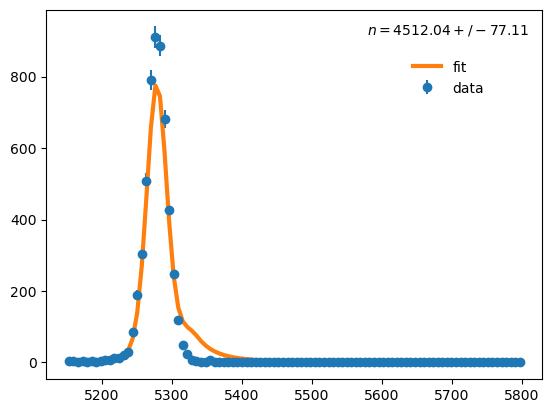

In [32]:
w, xe = np.histogram(Bu_M['b2dk_DD_p'], bins=100, range=[5150,5800])

# compute bin-wise density estimates
werr = w ** 0.5
cx = 0.5 * (xe[1:] + xe[:-1])
d = w 
derr = werr 
def norm_pdf(pdf):
    norm_term = np.mean(pdf)
    return np.array(pdf/norm_term)/len(pdf)

# define model and cost function
def model(x, nsig, nmisid):
    pdf = pdfs_data['b2dk_DD_p']['sig']
    pdf2 = pdfs_data['b2dk_DD_p']['misid']
    return nsig+nmisid, (nsig*pdf(x)+nmisid*pdf2(x))



cost = ExtendedUnbinnedNLL(Bu_M['b2dk_DD_p'].flatten(), model)

# fit the model
m = Minuit(cost, nsig=1000, nmisid=0)

m.migrad()
m.hesse()

# plot everything
result = m.values

print(result)

plt.errorbar(cx, w, yerr=derr, fmt="o", label="data")
plt.plot(cx, model(cx, result[0], result[1])[1], lw=3,
         label="fit")
plt.legend(frameon=False,
           title=f"$n = {m.values[0]:.2f} +/- {m.errors[0]:.2f}$\n");

In [9]:
%%time
from iminuit.cost import UnbinnedNLL
from scipy.optimize import minimize
def nll_extended(x, nsig, nmisid):
    pdf = pdfs_data['b2dk_DD_p']['sig']
    ntotal=nsig+nmisid
    nll = sum(np.log(nsig*pdf(x)/ntotal))
    
    print(nll)
    return nll

nll_extended.errordef = Minuit.LIKELIHOOD
x= Bu_M['b2dk_DD_p'].flatten()
ntotal = 10000
nsig = 1000
nmisid = 0

model = minimize(nll_extended, x, args=(nsig, nmisid), method="L-BFGS-B")


-1194.7079040754143
-1194.7079040754857
-1194.7079040754058
-1194.707904076394
-1194.7079040758017
-1194.707904075322
-1194.707904075507
-1194.707904075334
-1194.707904075875
-1194.7079040754854
-1194.7079040753117
-1194.707904075441
-1194.70790407543
-1194.7079040755004
-1194.7079040764852
-1194.707904075472
-1194.7079040753604
-1194.7079040754506
-1194.7079040754768
-1194.7079040755111
-1194.7079040744486
-1194.7079040753836
-1194.7079040753595
-1194.707904076403
-1194.7079040753183
-1194.7079040755013
-1194.707904075447
-1194.7079040759006
-1194.7079040753297
-1194.7079040755118
-1194.7079040747808
-1194.70790407547
-1194.7079040755061
-1194.7079040753144
-1194.7079040752428
-1194.7079040755107
-1194.7079040754481
-1194.7079040747617
-1194.7079040753113
-1194.7079040756419
-1194.707904075489
-1194.7079040754895
-1194.7079040755
-1194.7079040754234
-1194.7079040753185
-1194.7079040756053
-1194.7079040755382
-1194.707904074804
-1194.7079040754595
-1194.7079040754347
-1194.707904076506

In [10]:
print(f"The MLE estimate for f: {model.x[0]}")
print(f"The MLE estimate for nsig: {model.x[1]}")
print(f"The MLE estimate for ntotal: {model.x[1]+model.x[2]}")


The MLE estimate for f: 5278.736085116934
The MLE estimate for nsig: 5278.359182414137
The MLE estimate for ntotal: 10639.706200680606


NameError: name 'x_exp' is not defined

In [15]:
def prod_prob_dk_dd(Bsign, x, pdfs=[], Bu_M=[]):

    decay = 'b2dk_DD'
    fracDD = 0.30
    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_p, ampbar_dk_dd_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_m, ampbar_dk_dd_m)
    print('Cross terms: ', normalisationCrossTerms_p, normalisationCrossTerms_m)
    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_m)**2)
    print('Norms: ', normA_p, normAbar_p, normA_m, normAbar_m)

    sig_prob_p = prod_totalAmplitudeSquared_XY_test(1, amp_dk_dd_p, ampbar_dk_dd_p, x, pdfs[decay+'_p'], pdfs[decay+'_m'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = prod_totalAmplitudeSquared_XY_test(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, pdfs[decay+'_p'], pdfs[decay+'_m'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])

    misid_prob_p = prod_totalAmplitudeSquared_DPi_XY_test(1, amp_dk_dd_p, ampbar_dk_dd_p, x, pdfs[decay+'_p'], pdfs[decay+'_m'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_m = prod_totalAmplitudeSquared_DPi_XY_test(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, pdfs[decay+'_p'], pdfs[decay+'_m'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
#    comb_prob_p = prod_comb(amp_dk_dd_p, ampbar_dk_dd_p, x, pdfs[decay+'_p'], Bu_M[decay+'_p'], fracDD=fracDD)
#    comb_prob_m = prod_comb(amp_dk_dd_m, ampbar_dk_dd_m, x, pdfs[decay+'_m'], Bu_M[decay+'_m'], fracDD=fracDD)
#    low_prob_p = prod_low(1, amp_dk_dd_p, ampbar_dk_dd_p, x, pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low')
#    low_prob_m = prod_low(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low')
#    low_misID_prob_p = prod_low(1, amp_dk_dd_p, ampbar_dk_dd_p, x, pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_misID')
#    low_misID_prob_m = prod_low(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_misID')
#    low_Bs2DKPi_prob_p = prod_low(1, amp_dk_dd_p, ampbar_dk_dd_p, x, pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_Bs2DKPi')
#    low_Bs2DKPi_prob_m = prod_low(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_Bs2DKPi')


    total_yield = amp_Data_dk_dd_p.shape[1] + amp_Data_dk_dd_m.shape[1]
    
    normalisation_Bplus = totalAmplitudeSquared_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)
    misid_normalisation_Bplus = totalAmplitudeSquared_DPi_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    misid_normalisation_Bminus = totalAmplitudeSquared_DPi_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x) 
#    comb_normalisation_Bplus = (normA_p + normAbar_p)*0.5*fracDD + (1-fracDD)
#    comb_normalisation_Bminus = (normA_m + normAbar_m)*0.5*fracDD + (1-fracDD)
#    low_normalisation_Bplus = normAbar_p
#    low_normalisation_Bminus = normA_m

    prob_p = {}
    prob_m = {}
    prob_p['sig'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)))
    prob_m['sig'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)))
    prob_m['misid'] = (1/total_yield*((misid_prob_m/misid_normalisation_Bminus)))
    prob_p['misid'] = (1/total_yield*((misid_prob_p/misid_normalisation_Bplus)))
    
#    prob_p['sig'] = (1*((sig_prob_p/normalisation_Bplus)))
#    prob_m['sig'] = (1*((sig_prob_m/normalisation_Bminus)))
#    prob_m['misid'] = (1*((misid_prob_m/misid_normalisation_Bminus)))
#    prob_p['misid'] = (1*((misid_prob_p/misid_normalisation_Bplus)))
#    prob_p['comb'] = (1/total_yield*((comb_prob_p/comb_normalisation_Bplus)))
#    prob_m['comb'] = (1/total_yield*((comb_prob_m/comb_normalisation_Bminus)))
#    prob_p['low'] = (1/total_yield*((low_prob_p/low_normalisation_Bplus)))
#    prob_m['low'] = (1/total_yield*((low_prob_m/low_normalisation_Bminus)))
#    prob_p['low_misID'] = (1/total_yield*((low_misID_prob_p/low_normalisation_Bplus)))
#    prob_m['low_misID'] = (1/total_yield*((low_misID_prob_m/low_normalisation_Bminus)))
#    prob_p['low_Bs2DKPi'] = (1/total_yield*((low_Bs2DKPi_prob_p/low_normalisation_Bplus)))
#    prob_m['low_Bs2DKPi'] = (1/total_yield*((low_Bs2DKPi_prob_m/low_normalisation_Bminus)))
                            
    if Bsign ==1:
        return prob_p
    else:
        return prob_m


In [16]:
def plotOn(data=[], var=[], decay=decay, weights=[], nbins=100, ax=None, range=[5150, 5800]):

    print(var[decay].shape)
    density=False
    colors={'sig': 'blue', 'misid': 'yellowgreen', 'comb': 'violet', 'low': 'pink', 'low_misID': 'silver', 'low_Bs2DKPi': 'green'}
    filled={'sig': False, 'misid': False, 'comb': True, 'low': True, 'low_misID': True, 'low_Bs2DKPi': True}
    scale_factor = len(data[decay].flatten())/len(var[decay].flatten())
    bin_edges = np.linspace(range[0], range[1], nbins+1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    # Assuming s1 is sorted and binned accordingly, this is a placeholder for counting entries per bin
    counts, _ = np.histogram(data[decay], bins=bin_edges, density=density)
    # Calculate the standard deviation for the error bars
    std_devs = np.sqrt(counts)
    ax.errorbar(bin_centers, counts, yerr=std_devs, fmt='+', color='darkviolet',  label='Toy Data')
    #for key in prob.keys():
    #ax.hist(var[decay], bins=100, histtype='step', weights=weights['sig']*data[decay].shape[1], label='sig')
    #ax.hist([var[decay], var[decay], var[decay], var[decay], var[decay], var[decay]], bins=100, histtype='step', stacked=True, weights=[weights[key]*var[decay].shape[1] for key in weights.keys()], label=[key for key in weights.keys()])
    keys=[ 'misid', 'sig'] 
    if decay.split('_')[0] == 'b2dk':
        keys=['misid', 'sig']
        colors={'sig': 'yellowgreen', 'misid': 'blue', 'comb': 'violet', 'low': 'pink', 'low_misID': 'silver', 'low_Bs2DKPi': 'green'}

    ax.hist([var[decay] for key in keys], bins=100, histtype='step', stacked=False, weights=[(weights[key].numpy().flatten()*scale_factor) for key in keys], label=[key for key in keys], color=[colors[key] for key in keys], density=density)

    sum_weights = np.zeros(weights[keys[0]].numpy().shape)
    for key in keys:
        sum_weights += weights[key]
    ax.hist(var[decay], weights=sum_weights.numpy().flatten()*scale_factor, color='red', label='Total',bins=100, histtype='step', density=density)
    ax.legend()

    ax.set_xlabel('$M(B^{\pm})$')

In [17]:
pdfs_mc = {}
s12_mc = {}
s13_mc = {}
Bu_M_mc = {}
for decay in ['b2dk_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        print('--- INFO: Preparing pdfs for %s...'%new_decay)
        s12_mc[new_decay], s13_mc[new_decay] = getMass(new_decay, 'int')
        Bu_M_mc[new_decay] = np.linspace(5150, 5800, s12_mc[new_decay].shape[0])
        pdfs_mc[new_decay] = preparePdf_data(Bu_M_mc[new_decay], varDict, decay)


--- INFO: Preparing pdfs for b2dk_DD_p...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Preparing pdfs for b2dk_DD_m...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...


In [18]:
prob = prod_prob_dk_dd(1, x, pdfs_mc, Bu_M_mc)
decay = 'b2dk_DD_p'

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(8*2, 6*2))
ax0.scatter(s12_data[decay], s13_data[decay],s=0.1)
ax0.set_xlabel('$s_-$')
ax0.set_ylabel('$s_+$')



plotOn(data=Bu_M, var=Bu_M_mc, decay=decay, weights=prob, nbins=100, ax=ax1,range=[5150, 5800])
plotOn(data=s12_data, var=s12_mc, decay=decay, weights=prob, nbins=100, ax=ax2, range=[0.3, 3.2])
plotOn(data=s13_data, var=s13_mc, decay=decay, weights=prob, nbins=100, ax=ax3, range=[0.3, 3.2])



plt.show()

Cross terms:  (<tf.Tensor: shape=(), dtype=float64, numpy=23.066631232620665>, <tf.Tensor: shape=(), dtype=float64, numpy=0.06859127162202182>) (<tf.Tensor: shape=(), dtype=float64, numpy=23.01878504047328>, <tf.Tensor: shape=(), dtype=float64, numpy=-0.07173927551781276>)
Norms:  tf.Tensor(185.2536116205553, shape=(), dtype=float64) tf.Tensor(185.43130616599933, shape=(), dtype=float64) tf.Tensor(185.53439176823443, shape=(), dtype=float64) tf.Tensor(185.51281192627818, shape=(), dtype=float64)


IndexError: tuple index out of range

In [ ]:
prob = prod_prob_dk_dd(-1, x, pdfs_mc, Bu_M_mc)
decay = 'b2dk_DD_m'

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(8*2, 6*2))
ax0.scatter(s12_data[decay], s13_data[decay],s=0.1)
ax0.set_xlabel('$s_-$')
ax0.set_ylabel('$s_+$')



plotOn(data=Bu_M, var=Bu_M_mc, decay=decay, weights=prob, nbins=100, ax=ax1,range=[5150, 5800])
plotOn(data=s12_data, var=s12_mc, decay=decay, weights=prob, nbins=100, ax=ax2, range=[0.3, 3.2])
plotOn(data=s13_data, var=s13_mc, decay=decay, weights=prob, nbins=100, ax=ax3, range=[0.3, 3.2])




plt.show()

: 

In [ ]:
tf.math.reduce_sum(prob['sig'])


: 

In [ ]:
x_exp[6]/2

: 

In [ ]:
tf.math.reduce_sum(prob['misid'])

: 

In [ ]:
x_exp[7]/2

: 

In [ ]:
x_exp[6]/(x_exp[6]+x_exp[7])

: 